In [1]:
import alphapept.quantification
from tqdm import tqdm as tqdm
import numpy as np
import pandas as pd
from itertools import combinations
from numba.typed import List
from time import time
from tqdm import tqdm
import alphapept.quantification
import warnings

n_samples = 20

column_combinations = List()
[column_combinations.append(_) for _ in combinations(range(n_samples), 2)]

results = []


for run in tqdm(range(200)):
    for n_sequences in range(2,20):

        signal, sample, ground_truth = alphapept.quantification.generate_dummy_data(n_sequences, n_samples)
        ratios = alphapept.quantification.get_protein_ratios(signal.values, column_combinations)

        for method in ['L-BFGS-B', 'SLSQP', 'Powell', 'trf']:
            error = False
            start = time()

            try:
                solution, success = alphapept.quantification.solve_profile(ratios, method)
                if not success:
                    solution = np.zeros(ratios.shape[0])
            except Exception as e:
                error = True
                solution = np.zeros(ratios.shape[0])

            mape = np.mean(np.abs((solution-ground_truth)/ground_truth))

            end = time()

            time_elapsed_s = (end-start)

            results.append((method, time_elapsed_s, mape, error, success, n_sequences, run))

result_df = pd.DataFrame(results, columns=['Method', 'Time Elapsed (s)', 'Mean absolute percentage error', 'Errors', 'Success', 'Sequences', 'Run'])


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [43:24<00:00, 13.02s/it]


In [4]:
results

[('L-BFGS-B', 1.225381851196289, 1.0, False, False, 2, 0),
 ('SLSQP', 0.002064943313598633, 1.0, False, False, 2, 0),
 ('Powell', 0.64225172996521, 1.0, False, False, 2, 0),
 ('trf', 0.0, 1.0, True, False, 2, 0),
 ('L-BFGS-B', 0.010717153549194336, 1.0, False, False, 3, 0),
 ('SLSQP', 0.0, 1.0, False, False, 3, 0),
 ('Powell', 0.6857795715332031, 1.0, False, False, 3, 0),
 ('trf', 0.0, 1.0, True, False, 3, 0),
 ('L-BFGS-B', 0.010171890258789062, 1.0, False, False, 4, 0),
 ('SLSQP', 0.00811314582824707, 1.0, False, False, 4, 0),
 ('Powell', 0.643974781036377, 1.0, False, False, 4, 0),
 ('trf', 0.0, 1.0, True, False, 4, 0),
 ('L-BFGS-B', 0.01624274253845215, 1.0, False, False, 5, 0),
 ('SLSQP', 0.0020689964294433594, 1.0, False, False, 5, 0),
 ('Powell', 0.6540400981903076, 1.0, False, False, 5, 0),
 ('trf', 0.0, 1.0, True, False, 5, 0),
 ('L-BFGS-B', 0.010198116302490234, 1.0, False, False, 6, 0),
 ('SLSQP', 0.008084774017333984, 1.0, False, False, 6, 0),
 ('Powell', 0.6382448673248291,

In [5]:
result_df['Error relative to mean'] = result_df['Mean absolute percentage error'] / result_df.groupby(['Sequences','Run'])['Mean absolute percentage error'].transform(np.mean)
result_df_ = result_df[result_df["Success"]]

grouped_mean = result_df_.groupby(['Method']).mean().reset_index()

grouped_std = result_df_.groupby(['Method']).std().reset_index()
grouped_cnt = result_df_.groupby(['Method']).count().reset_index()

<Figure size 236.3x236.3 with 0 Axes>

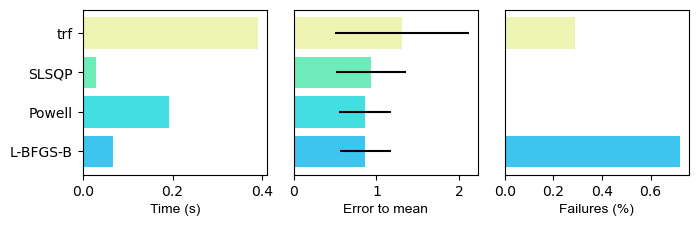

In [6]:
import matplotlib.pyplot as plt

dark_blue = '#17212b'
light_blue = '#3dc5ef'
teal= '#42dee1'
green = '#6eecb9'
yellow = '#eef5b3'

colors = [light_blue, teal, green, yellow]

hfont = {'fontname':'Arial', 'size':10}
plt.figure(figsize=(2.363,2.363)) #60x60

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(2.363*3,2.363))

ax1.barh(grouped_mean['Method'], grouped_mean['Time Elapsed (s)'], color = colors)

ax1.set_xlabel('Time (s)', **hfont)

ax2.barh(grouped_mean['Method'], grouped_mean['Error relative to mean'], xerr = grouped_std['Error relative to mean'].values, color = colors)

ax2.set_xlabel('Error to mean', **hfont)

ax3.barh(grouped_mean['Method'], (1-grouped_cnt['Success']/max(grouped_cnt['Success']))*100 , color = colors)

ax3.set_xlabel('Failures (%)', **hfont)

ax2.set_yticks([])
ax3.set_yticks([])

plt.tight_layout()
plt.savefig('./figures/06_A.pdf')
plt.show()


In [7]:
grouped_mean.iloc[3]['Time Elapsed (s)'] / grouped_mean.iloc[2]['Time Elapsed (s)']

13.375667875778296

In [8]:
grouped_cnt['Success']/max(grouped_cnt['Success'])

0    0.992788
1    1.000000
2    1.000000
3    0.997115
Name: Success, dtype: float64

In [9]:
grouped_cnt

,Method,Time Elapsed (s),Mean absolute percentage error,Errors,Success,Sequences,Run,Error relative to mean
0,L-BFGS-B,2065,2065,2065,2065,2065,2065,2065
1,Powell,2080,2080,2080,2080,2080,2080,2080
2,SLSQP,2080,2080,2080,2080,2080,2080,2080
3,trf,2074,2074,2074,2074,2074,2074,2074
